# Experiment Notebook

In [567]:
import sys

import numpy as np
import pandas as pd

from src.fts_src import FinancialTimeSeriesSparseModel
from src.metrics import rmsre
from src.mesax import meSAX
from src.data_generator import download_data


from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

import yfinance as yf

import matplotlib.pyplot as plt

# global matplotlib settings fontsize
plt.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and split data

In [555]:
START_DATE = '2010-01-01'
END_DATE = '2020-01-01'
TRAIN_PROPORTION = 0.8

In [596]:
prices = download_data(START_DATE, END_DATE).dropna()
train_price, test_price = train_test_split(prices, train_size=TRAIN_PROPORTION, test_size=1-TRAIN_PROPORTION, shuffle=False)

log_return = np.log(prices).diff().dropna() * 1e4 # put in bps
train_log_return, test_log_return = train_test_split(log_return, train_size=TRAIN_PROPORTION, test_size=1-TRAIN_PROPORTION, shuffle=False)

## Visual overview of the data

In [597]:
TEST_ASSET_NAME = 'CAC 40'

Prices

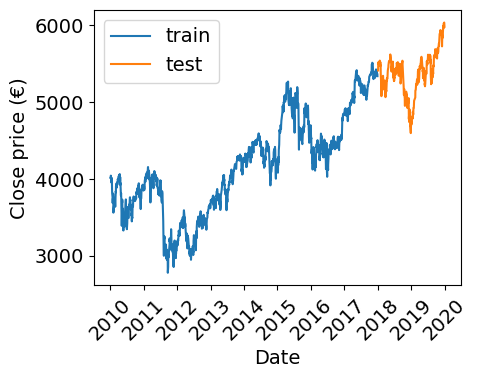

In [598]:
# train test split

plt.figure(figsize=(5, 4))
# plot the train and test data
plt.plot(train_price[TEST_ASSET_NAME], label='train')
plt.plot(test_price[TEST_ASSET_NAME], label='test')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close price (€)')
plt.tight_layout()
plt.savefig('train_test_data.pdf')
plt.show()

Log returns

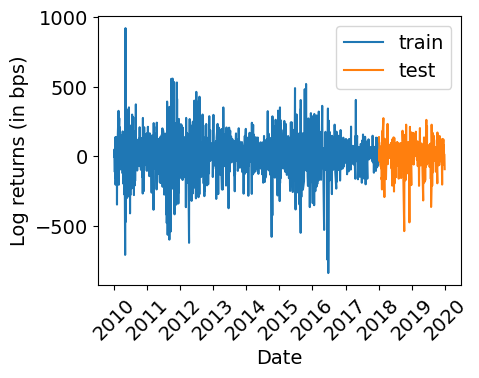

In [599]:
plt.figure(figsize=(5, 4))
# plot the train and test data
plt.plot(train_log_return[TEST_ASSET_NAME], label='train')
plt.plot(test_log_return[TEST_ASSET_NAME], label='test')

plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Log returns (in bps)')
plt.tight_layout()
plt.savefig('train_test_log_returns.pdf')
plt.show()

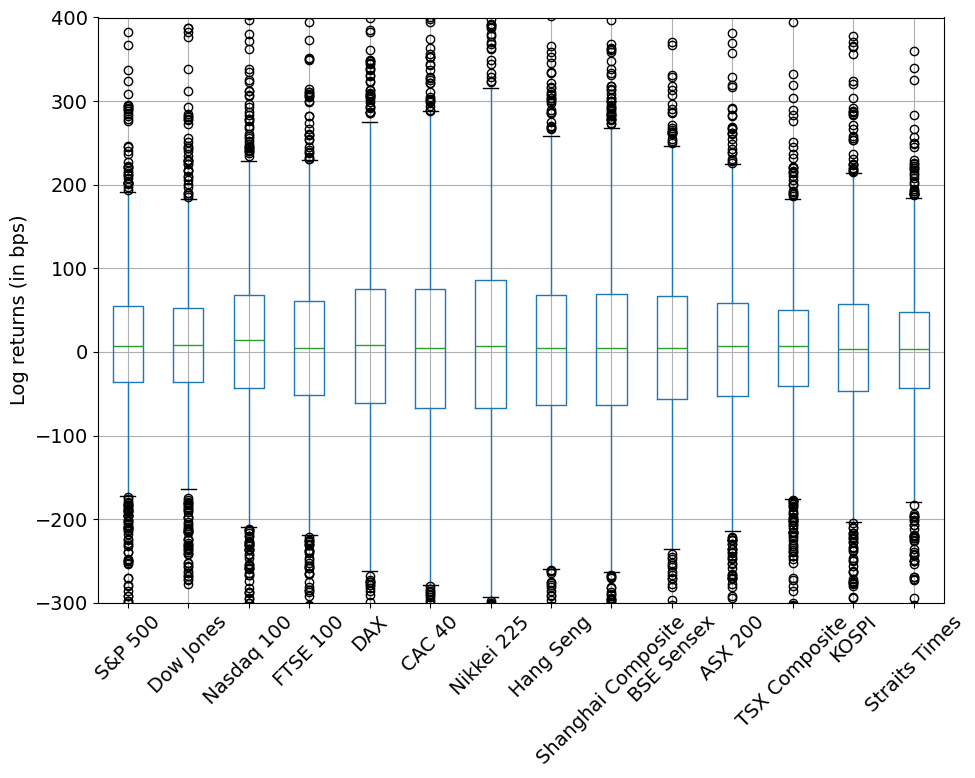

In [614]:
# boxplot of the log returns
plt.figure(figsize=(10, 8))
train_log_return.boxplot()
plt.xticks(rotation=45)
plt.ylabel('Log returns (in bps)')
plt.ylim(-300, 400)
plt.tight_layout()

In [617]:
# get the average, annualized volatility , skewness of the log returns
mean = train_log_return.mean()
std = train_log_return.std() * np.sqrt(252)
skew = train_log_return.skew()
kurtosis = train_log_return.kurtosis()
print(pd.concat([mean, std, skew, kurtosis], axis=1, keys=['mean', 'std', 'skew', 'kurtosis']).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  mean &      std &  skew &  kurtosis \\
\midrule
S\&P 500            &  5.60 &  1647.70 & -0.35 &      4.84 \\
Dow Jones          &  5.53 &  1533.01 & -0.28 &      4.02 \\
Nasdaq 100         &  7.96 &  1893.43 & -0.29 &      3.36 \\
FTSE 100           &  2.12 &  1717.30 & -0.20 &      3.25 \\
DAX                &  4.95 &  2220.26 & -0.29 &      2.97 \\
CAC 40             &  1.85 &  2304.17 & -0.26 &      4.08 \\
Nikkei 225         &  4.93 &  2462.38 & -1.14 &     12.75 \\
Hang Seng          &  2.03 &  1996.44 & -0.13 &      2.83 \\
Shanghai Composite &  0.10 &  2534.12 & -0.77 &      5.59 \\
BSE Sensex         &  4.26 &  1754.11 & -0.10 &      2.53 \\
ASX 200            &  1.44 &  1618.57 & -0.19 &      2.35 \\
TSX Composite      &  2.03 &  1414.85 & -0.33 &      3.25 \\
KOSPI              &  2.43 &  1676.09 & -0.55 &      5.70 \\
Straits Times      &  1.04 &  1428.43 & -0.29 &      3.80 \\
\bottomrule
\end{tabular}



/var/folders/k1/n25_cgpj17b12lgf2qvp_t_h0000gn/T/ipykernel_20347/3105509466.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([mean, std, skew, kurtosis], axis=1, keys=['mean', 'std', 'skew', 'kurtosis']).round(2).to_latex())


## Stationarity test

In [584]:
adfuller(prices[TEST_ASSET_NAME])

(-0.7434869840533467,
 0.8351616758316877,
 4,
 1924,
 {'1%': -3.43375335030681,
  '5%': -2.863043384324392,
  '10%': -2.5675703430245376},
 20724.115046522085)

In [585]:
adfuller(log_return[TEST_ASSET_NAME])

(-24.65456407259553,
 0.0,
 3,
 1924,
 {'1%': -3.43375335030681,
  '5%': -2.863043384324392,
  '10%': -2.5675703430245376},
 -10927.38509541318)

## m-eSAX representation

In [518]:
model = meSAX(
  alphabet_size=64,
  rolling_window_size=60,
  rolling_window_stride=10, 
  paa_window_size=10
)

Compression ratio: 1.1111111111111112
RMSRE: 0.017707851448582005


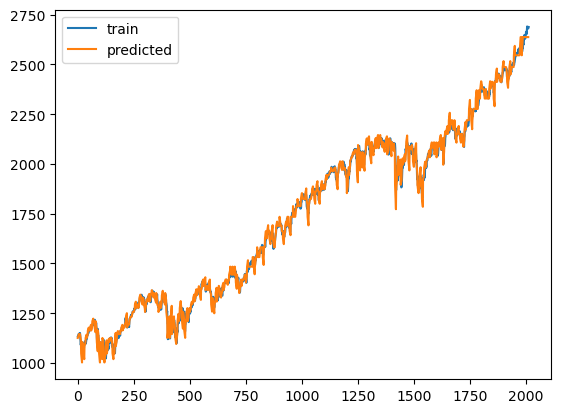

In [519]:
train_time_series = train.values.squeeze()
embds, compression_ratio = model.fit_transform(train_time_series, fitting_method='median')
prediction = model.predict(embds, sampling_method='slope')

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(train_time_series, prediction))
plt.plot(train_time_series, label='train')
plt.plot(prediction, label='predicted')
plt.legend()

Limitation of the fitting due to values that are capped/floored because not on the historical data.

Compression ratio: 1.1111111111111112
RMSRE: 1.2437305176481566


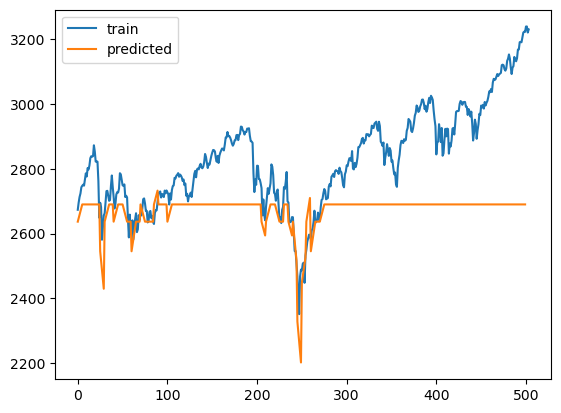

In [520]:
test_time_series = test.values.squeeze()
embds, compression_ratio = model.transform(test_time_series)
prediction = model.predict(embds, sampling_method='slope')

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(train_time_series, prediction))
plt.plot(test_time_series, label='train')
plt.plot(prediction, label='predicted')
plt.legend()

## Finanacial time series sparse representation coding (FT-SRC)

In [521]:
dict_atoms_number = 20
non_zero_coeff = 4
sliding_window_size = 30
sliding_window_stride = 10
max_iter = 100

In [522]:
model = FinancialTimeSeriesSparseModel(
    n_components=dict_atoms_number,
    n_nonzero_coefs=non_zero_coeff,
    window_size=sliding_window_size,
    stride=sliding_window_stride,
    max_iter=max_iter
)

In [523]:
train_time_series = train.values.squeeze()
model.fit(train_time_series)

[*] Segmenting time series into sliding windows...
[*] Learning dictionary from the segmented data...
[dict_learning] .

...................................................................................................
[*] Transforming the segmented data into sparse codes...


DictionaryLearning(max_iter=100, n_components=20, transform_max_iter=100,
                   transform_n_nonzero_coefs=4, verbose=True)

Compression ratio: 7.5
RMSRE: 0.005840220655058488


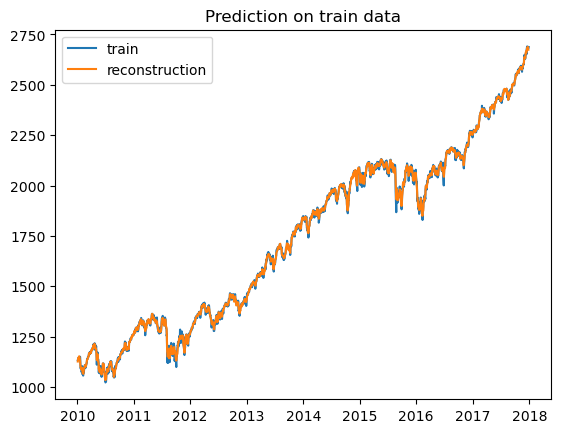

In [524]:
prediction, compression_ratio = model.predict(train_time_series)

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(train_time_series, prediction))

plt.plot(train.index, train_time_series, label='train')
plt.plot(train.index, prediction, label='reconstruction')
plt.title('Prediction on train data')
plt.legend()

Compression ratio: 7.5
RMSRE: 0.0066315974609682665


(18117.0, 18261.0)

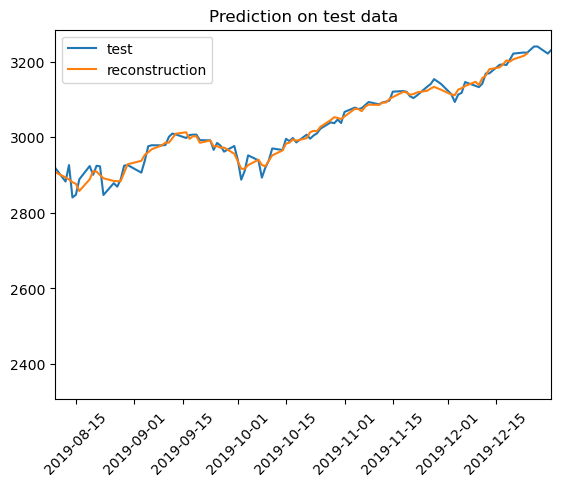

In [525]:
test_time_series = test.to_numpy()[:,0]
prediction, compression_ratio = model.predict(test_time_series)

print('Compression ratio:', compression_ratio)
print('RMSRE:', rmsre(test_time_series, prediction))

plt.plot(test.index, test_time_series, label='test')
plt.plot(test.index, prediction, label='reconstruction')
plt.title('Prediction on test data')
plt.xticks(rotation=45)
plt.legend()
plt.xlim(test.index[-100], test.index[-1])